# 사이킷런으로 수행하는 타이타닉 생존자 예측

## 필요한 라이브러리 로드 및 데이터읽기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
import platform
import os
from matplotlib import font_manager, rc

# 한글폰트 설치
path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = path).get_name()
rc('font', family = font_name)

# 마이너스 부호 표시 
plt.rcParams['axes.unicode_minus'] = False



In [4]:
os.getcwd()

'C:\\dataAnalysis\\philosophy_datascience\\01.ML\\03.Scikit-Learn'

In [33]:
titanic_df = pd.read_csv("./titanic/titanic_train.csv")
print("\n ##  학습 데이터 정보 ### \n")
print(titanic_df.info())


 ##  학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## 널값 처리 
* 사이킷런은 널값을 허용하지 않으므로 널값 처리방법 결정 필요

In [38]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace = True)
titanic_df['Cabin'].fillna('N', inplace = True)
titanic_df['Embarked'].fillna('N', inplace = True)

In [39]:
print('컬럼별 데이터 세트 널 값 갯수 ', titanic_df.isnull().sum())

컬럼별 데이터 세트 널 값 갯수  PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [40]:
print('전체 데이터 세트 널 값 갯수 ', titanic_df.isnull().sum().sum())

전체 데이터 세트 널 값 갯수  0


## 문자열 feature들의 값 분류 확인

In [44]:
print('Sex값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 : \n', titanic_df['Embarked'].value_counts())

Sex값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin값 분포 : 
 N              687
B96 B98          4
C23 C25 C27      4
G6               4
F33              3
              ... 
E68              1
A24              1
B73              1
C90              1
B42              1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [53]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


## 머신러닝 알고리즘 적용전 EDA
* 어떤 유형의 승객이 생존확률이 높았는지 확인
* 성별이 생존율에 영향을 주었는가?
* 좌석의 등급은 생존률에 영향을 주었는가?

### 성별과 생존율

In [54]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

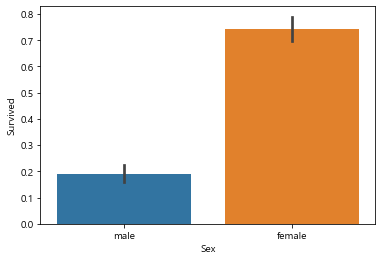

In [56]:
sns.barplot(x = 'Sex', y = 'Survived', data = titanic_df)

### 객실 등급과 생존율
* 힘없고 가난한 자는 100년전에도 동일하게 죽어갔다.

In [57]:
titanic_df.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

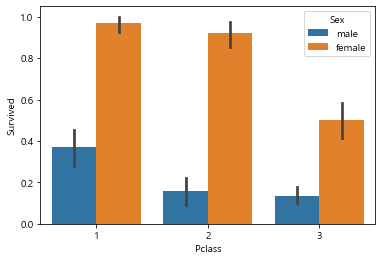

In [60]:
sns.barplot(x = 'Pclass', y = 'Survived', data = titanic_df, hue = 'Sex')

### 성별에 따른 생존율

In [62]:
# 입력 age에 따라 구분 값을 변환하는 함수 설정, DataFrame의 apply lambda식에 사용
def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
    return cat

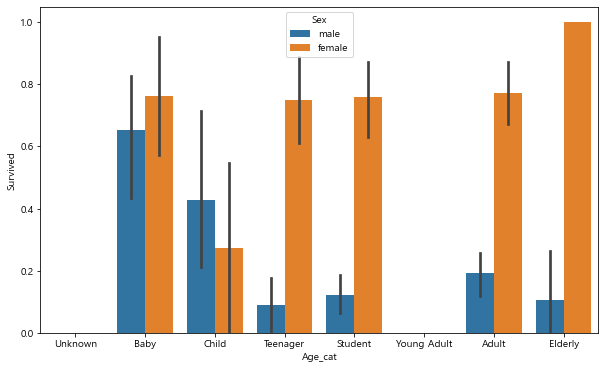

In [67]:
# 막대 그래프의 크기 figure설정
plt.figure(figsize = (10, 6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda식에 위에서 생성한 get_category()함수를 반환값으로 지정함.
# get_category(x)는 입력값으로 'Age'칼럼값을 받아서 해당하는 cat반환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))
sns.barplot(x= 'Age_cat', y= 'Survived', hue = 'Sex', data = titanic_df, order = group_names)

In [70]:
titanic_df.drop(labels = 'Age_cat', axis = 1, inplace = True, errors = 'ignore')  # ignore는 에러가 나더라도 무시함.

## 문자열 카테고리 피처를 숫자형 카테고리 피처로 변환
* 인코딩은 사이킷런의 LabelEncoder클래스 이용
* `fit()`과 `transform()`메소드 사용

In [71]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

In [72]:
titanic_df = encode_features(titanic_df)

In [73]:
titanic_df.head(n = 3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3


## 데이터 전처리 함수 생성

In [88]:
# 널처리 함수 
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace  = True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거 
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True,errors = 'ignore')
    return df

# 레이블 인코딩 수행
def format_features(df):
    features = ['Cabin', 'Sex', 'Embarked']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 앞에서 설정한 데이터 전처리 함수 호출 
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

### 원본 데이터 재가공

In [83]:
# 원본 데이터를 재로딩, 
# 피처 데이터세트와 레이블 데이터 세트 추출.
titanic_df = pd.read_csv("./titanic/titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)

In [89]:
X_titanic_df = transform_features(X_titanic_df)

### 테스트 데이터 세트 추출
* test_size = 0.2의 의미는 훈련용 데이터세트가 전체의 80%이고 검증용이 20%라는 의미.

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

### 생성한 ML모델에 대한 학습 , 예측, 성능 평가

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [121]:
# 결정트리,Random Forest, 로지스틱 회귀를 위한 사이킷런 Classifier클래스 생성
dt_clf = DecisionTreeClassifier(random_state = 11)
rf_clf = RandomForestClassifier(random_state = 11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier학습 /에측 평가 
dt_clf.fit(X_train, y_train)
df_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, df_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticeRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('Regression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7989
RandomForestClassifier 정확도 : 0.8436
Regression 정확도 : 0.8603


In [103]:
help(DecisionTreeClassifier.fit)

Help on function fit in module sklearn.tree._classes:

fit(self, X, y, sample_weight=None, check_input=True, X_idx_sorted=None)
    Build a decision tree classifier from the training set (X, y).
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The training input samples. Internally, it will be converted to
        ``dtype=np.float32`` and if a sparse matrix is provided
        to a sparse ``csc_matrix``.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        The target values (class labels) as integers or strings.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, then samples are equally weighted. Splits
        that would create child nodes with net zero or negative weight are
        ignored while searching for a split in each node. Splits are also
        ignored if they would result in any single class carrying a
        negative weight in e

In [104]:
help(DecisionTreeClassifier.predict)

Help on function predict in module sklearn.tree._classes:

predict(self, X, check_input=True)
    Predict class or regression value for X.
    
    For a classification model, the predicted class for each sample in X is
    returned. For a regression model, the predicted value based on X is
    returned.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        The input samples. Internally, it will be converted to
        ``dtype=np.float32`` and if a sparse matrix is provided
        to a sparse ``csr_matrix``.
    
    check_input : bool, default=True
        Allow to bypass several input checking.
        Don't use this parameter unless you know what you do.
    
    Returns
    -------
    y : array-like of shape (n_samples,) or (n_samples, n_outputs)
        The predicted classes, or the predict values.



* 3개의 알고리즘 중 LogisticRegression이 타 알고리즘에 비해 높은 정확도를 갖지만, 아직 최적화작업을 수행하지 않았고, 데이터 양도 충분치 않기때문에 어떤 알고리즘이 성능이 더 좋다고 평가 할 수는 없다.
* 교차검증으로 결정트리 모델을 평가해보자.

### 교차검증
* KFOLD클래스 , cross_val_score(), GridSearchCV클래스 

#### KFOLD 교차 검증 수행

In [113]:
help(KFold.split)

Help on function split in module sklearn.model_selection._split:

split(self, X, y=None, groups=None)
    Generate indices to split data into training and test set.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    y : array-like of shape (n_samples,), default=None
        The target variable for supervised learning problems.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    Yields
    ------
    train : ndarray
        The training set indices for that split.
    
    test : ndarray
        The testing set indices for that split.



In [122]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # 폴드 세트를 5개인 KFold객체를 생성, 폴드 수만큼 예측결과 저장을 위한  리스트 객체 생성.
    kfold = KFold(n_splits=folds)
    scores = []
    
    # KFold 교차 검증 수행. 
    for iter_count , (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 정확도 계산 
        clf.fit(X_train, y_train) 
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))     
    
    # 5개 fold에서의 평균 정확도 계산. 
    mean_score = np.mean(scores)
    print("평균 정확도: {0:.4f}".format(mean_score)) 
# exec_kfold 호출
exec_kfold(dt_clf , folds=5)

교차 검증 0 정확도: 0.7486
교차 검증 1 정확도: 0.7640
교차 검증 2 정확도: 0.8202
교차 검증 3 정확도: 0.7809
교차 검증 4 정확도: 0.7921
평균 정확도: 0.7812


#### cross_val_score() 교차 검증 수행

In [128]:
from sklearn.model_selection import cross_val_score

In [130]:
help(cross_val_score)

Help on function cross_val_score in module sklearn.model_selection._validation:

cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)
    Evaluate a score by cross-validation
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    
    X : array-like of shape (n_samples, n_features)
        The data to fit. Can be for example a list, or an array.
    
    y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
        The target variable to try to predict in the case of
        supervised learning.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set. Only used in conjunction with a "Group" :term:`cv`

In [132]:
scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv = 5)

for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도 : {1:.4f}".format(iter_count, accuracy))
    
print("평균 정확도 {0:.4f}".format(np.mean(scores)))    

교차 검증 0 정확도 : 0.7486
교차 검증 1 정확도 : 0.7753
교차 검증 2 정확도 : 0.8090
교차 검증 3 정확도 : 0.7584
교차 검증 4 정확도 : 0.8034
평균 정확도 0.7789


#### GridSearchCV 클래스 이용
* 최적 하이퍼 파라미터 튜닝 성능 측정

In [134]:
from sklearn.model_selection import GridSearchCV

In [135]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either e

In [137]:
parameters = {"max_depth": [2, 3, 5, 10],
             "min_samples_split": [2, 3, 5],
             "min_samples_leaf": [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv = 5)
grid_dclf.fit(X_train, y_train)

print("GridSearchCV 최적 하이터 파라미터 : ", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도 : {0:.4f}".format(grid_dclf.best_score_))

best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 
dpredctions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredctions)
print("테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy))

GridSearchCV 최적 하이터 파라미터 :  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
GridSearchCV 최고 정확도 : 0.7993
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8659
